# Final Assignment: Opinion Miner

## Task and Data Analyses
<br>
<p style="text-align: justify">
When shopping for a variety of products online on a website like amazon, the customer is often confronted with the problem of a huge number of product reviews for each product. Customers usually want to read product reviews as a means to gain more inside about the products they are about to buy. But even reading a few reviews can be extremely time consuming, whereas scanning through thousands of reviews is not feasible. Therefore most of the information contained in reviews addressing the strengths and weaknesses of a product is currently not being presented to the users in an effective way. 
Opinion mining could combat this problem by finding features of products that are commonly being referring to in the reviews and summarizing the sentiment of the reviews as discussed in prior work.<sup>[1, 2]</sup> By doing so opinion mining could present positively and negatively seen features of a product to a user, making the buying experience superior to current models, as can be seen in <strong>Figure 1</strong>.</p>

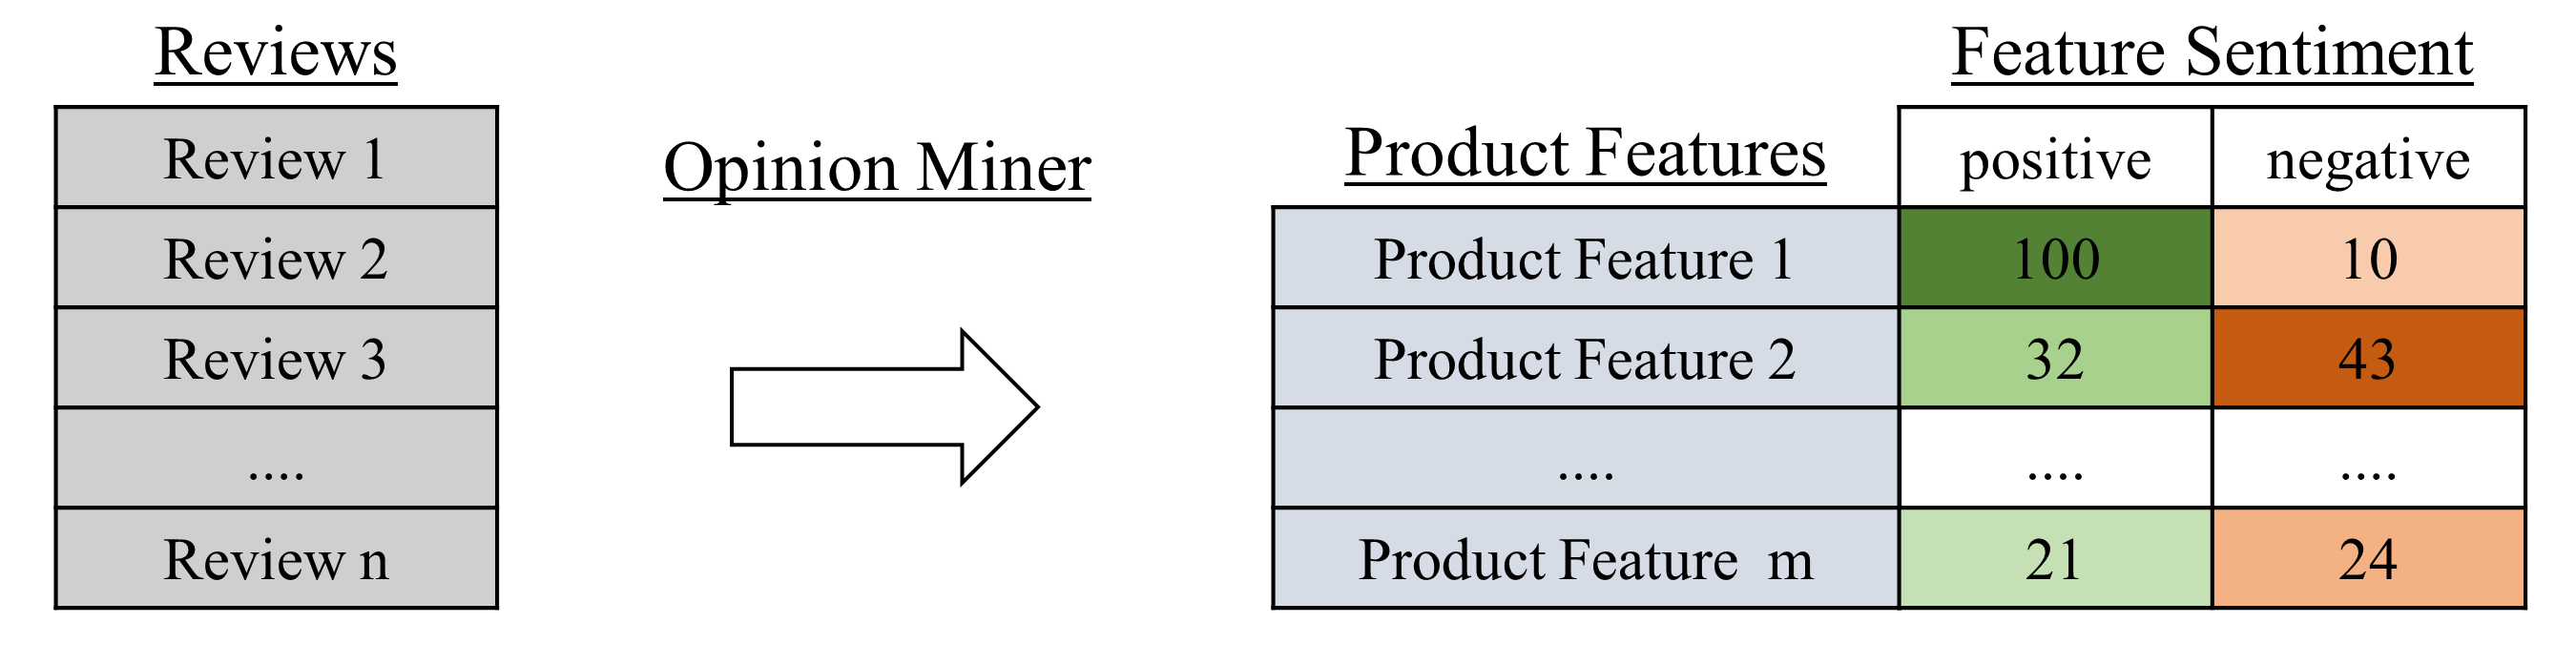
<p style="text-align: justify"><font size='2'>
<strong>Figure 1</strong>: <i>Illustration of the dimensionality reduction function performed by the opinion miner from n reviews containing text, to m product features with a positive and negative sentiment score. The review count n can be assumed to be much greater than the identified features m, as some products can receive thousands of online reviews.</i></font></p>

<p style="text-align: justify">
But how can a functional opinion miner be built?<br><br>
First the reviews of a particular product have to be collected in one place to be able to perform subsequent steps in the pipeline, which can also generally be referred to as data ingestion. In this task, a number of different txt files containing reviews for a variety of products have to be extracted and combined. Additionally, the reviews would have to be labelled by hand or by taking unsupervised labelling approaches. But because the labelling was already done by the researchers providing the dataset (source: <sup>[1, 2]</sup>), it can be disregarded for this task.<br>
    
    
The next step is to preprocess the labelled reviews. In this preprocessing step, the goal is to tokenize the dataset, lemmatize the words in the dataset, and to perform Part-of-Speech tagging. How the deployed algorithms work in detail will be further discussed under the data preprocessing section. The general goal of tokenizing is to map all the words in the dataset to a vector of one vector space. Representing the words as vectors enables the use of machine learning models later on. The goal of the lemmatization algorithm is to reduce every word to its lemma. This reduces the complexity, as words with the same origin are combined into the same lemma (as for example “being” and “to be”). POS tagging algorithms tag every created token with a POS tag from the tag set to find out whether a word is a noun or adjective and if a word is a subject or object in a respective sentence. All information obtained up until this step will be saved in tabular form using the pandas libary (see  <strong>Figure 2</strong>).<br>
    
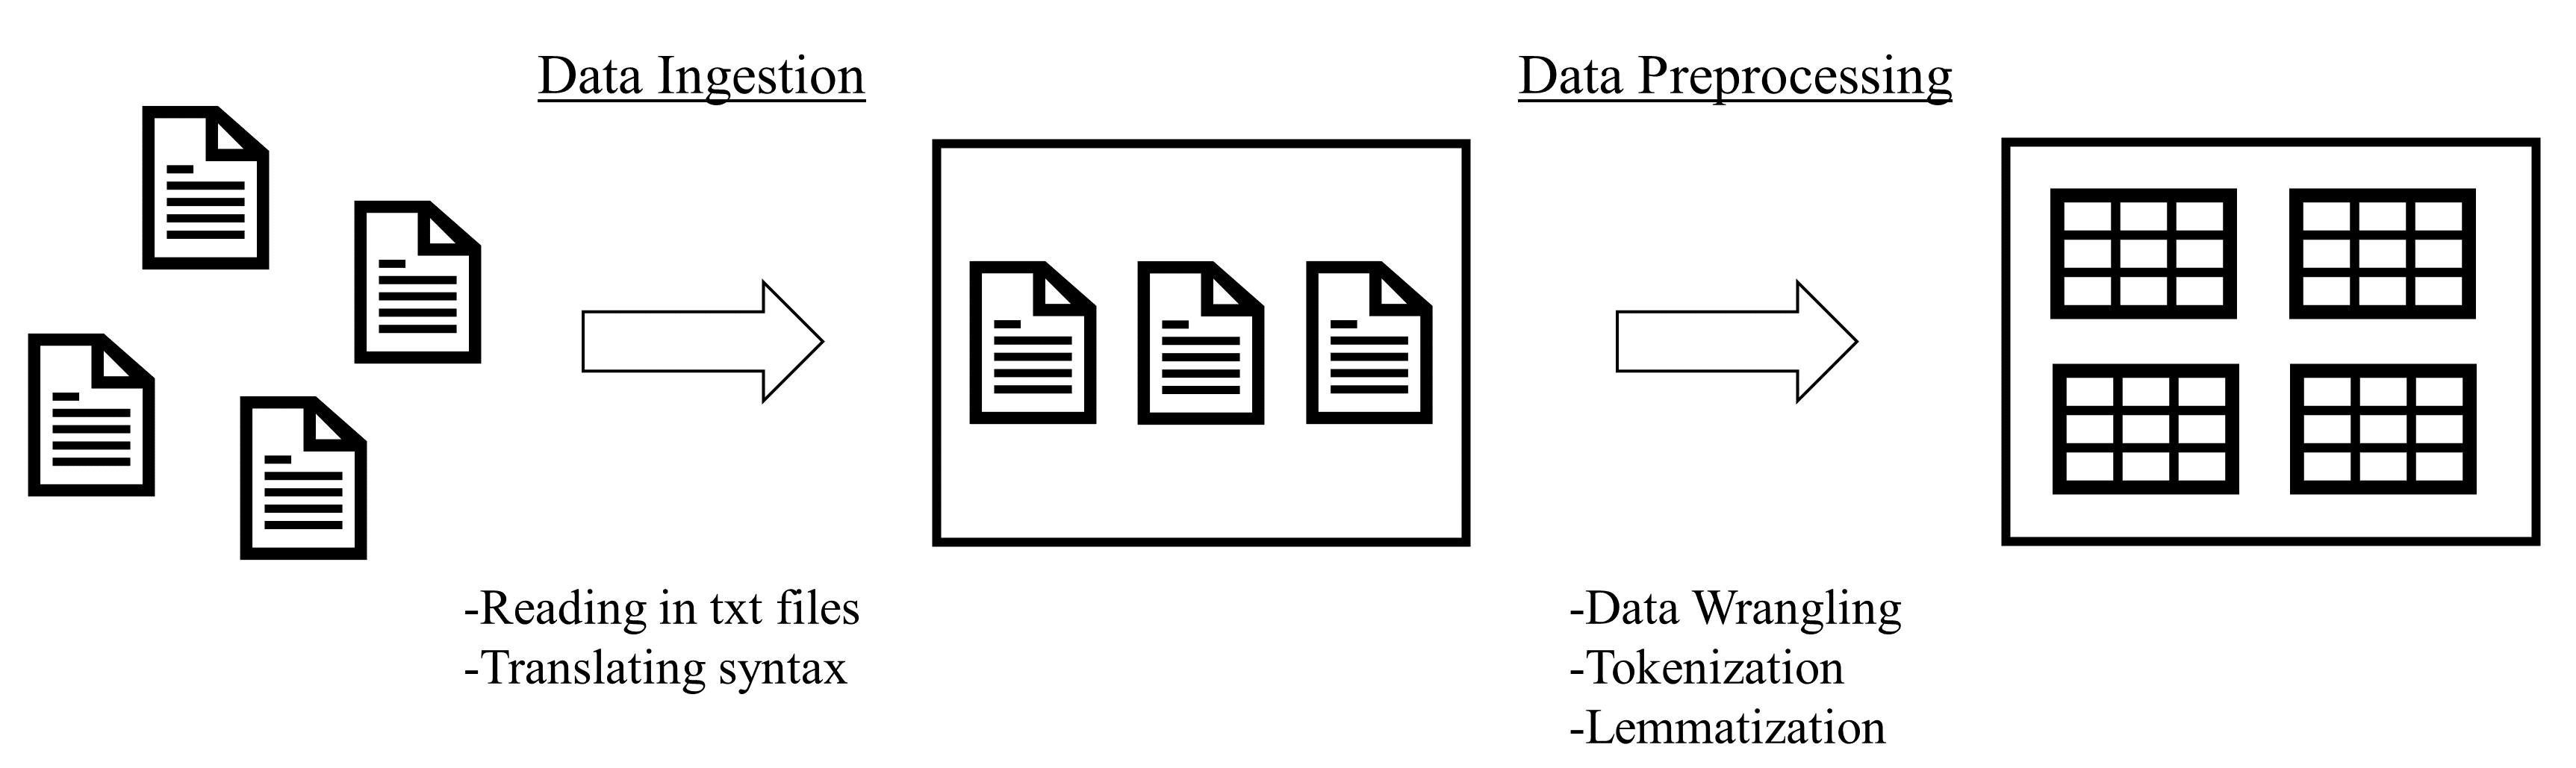    
<p style="text-align: justify"><font size='2'>
<strong>Figure 2</strong>: <i>Illustration showing the steps performed to ingest all review files into the same directory and to obtain a tokenized tabular datasets for further machine learning purposes.</i></font></p>    

    
In the next step, the product features have to be extracted from the review texts. Because the main product features discussed in the reviews were already identified (source: <sup>[1, 2]</sup>), this task can be regarded as supervised. Therefore any algorithm that extracts product features from the dataset can be compared with the product features given. The task will be performed by first applying prior knowledge gained in the preprocessing step (e.g. POS tags were obtained for every word in the dataset) to filter the potential product features. Subsequently two different algorithms will be used to extract the product features, which can consist of multiple words. Frequency counts and pointwise mutual information (PMI) will be used to extract monograms, bigrams and trigrams representing the product features. Differences between the approaches will be discussed below. <br>
    
    
After the feature extraction, sensitivity analysis will be performed to find out if a feature is seen positively or negatively in a review. To achieve this task, three steps will be taken. First, sentences will be divided into subsentences. In a second step, the subsentences that contain product features will be identified, lastly two algorithms will be deployed to measure the sentiment of these subsentences. The algorithms that will be compared are lexicon-based sentiment analysis and machine-learning based sentiment analysis. The exact algorithms deployed will be discussed in more detail in section “Sentiment analysis”. <br>

Lastly the individual algorithms deployed as well as the final performance will be analyzed and discussed. The performance will be optimized and the performance metrices as well as the final output of the opinion miner will be visualized.  
</p>

<p style="text-align: justify">

Key challenges of this task are connected to the input data (see <strong>Figure 3</strong>) and were identified as:
* In some reviews, product features are discussed but not named (e.g. “I loved it” referring to the picture quality).
* Sometimes, different names are given to the same product feature (e.g. “digital camera” vs. “camera”).
* Reviews can entail positive and negative sentiments in different chunks of sentences.
* Some reviews are extremely positive/negative towards the product features, whereas other reviews are more subtle.


</p>


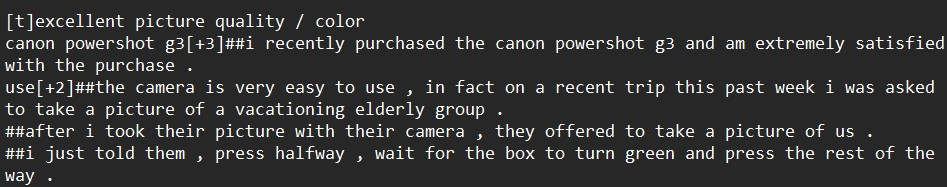
<p style="text-align: justify"><font size='2'>
<strong>Figure 3</strong>: <i>Snippet of the dataset obtained. Individual reviews start with tag [t], identified product features and score are mentioned before the sentence in which the features are addressed (e.g. use[+2]). Sentences are separated with ##.</i></font></p>

In [1]:
# Imports all below needed libraries 

# Used for data preprocessing and data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Surpresses pandas performance warnings
import warnings
warnings.simplefilter(action='ignore',
                      category=pd.errors.PerformanceWarning)

# Used for NLP purposes
import spacy
import nltk
import re
from nltk.probability import FreqDist
from nltk.corpus import opinion_lexicon
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.collocations import TrigramCollocationFinder, TrigramAssocMeasures

# Used for machine learning purposes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

# Used for the evaluation step
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Data Preprocessing
<br>
<p style="text-align: justify">

</p>

As frequently discussed in the course, most NLP applications and machine learning algorithms do not work on sentences or collections of words. This is because words and sentences tend to differ in length from each other and therefore to differ in dimensionality. For machine learning applications it is crucial for input data to have the same dimensionality. Some algorithms, as for example the k-means clustering algorithm, also only work, if the distance between two datapoints in the dataset is well defined. The below data preprocessing pipeline translates words into vectors on a predefined vectorspace. This ensures that distances between datapoints are well defined and that all datapoints have the same dimensionality.<br><br>

In the data preprocessing step, the product review txt files were first converted into tabular datasets with the function process_txt_to_df using the pandas library (source: <sup>[3]</sup>). 
The process_txt_to_df function works by scanning every line of every review for features and sentiments, which where mentioned at the beginning of the lines (e.g. use[2+]). No distinction was made between slightly positive/negative and strongly positive/negative reviews. Once the end of a review was reached, the mean sentiment was determined and the sentiment scores (+1 for positive sentiment or -1 for negative sentiment) for every feature and all mentioned features as well as the review text were saved in a pandas data frame (e.g. cam_1_df). After all reviews were processed, all features found as well as the mean sentiment scores were determined and saved in another type of data frame (e.g. cam_1_features). A third type of data frame was created, mapping all text lines of every review to the respective features and sentiment scores (e.g. cam_1_line_df), but that data frame type was not further used in subsequent steps. 
Problems were discovered with 5 txt files (ipod.txt, Computer.txt, Router.txt, Speaker.txt, Canon PowerShot SD500.txt), which were not formatted to include separations between individual reviews, but only one large chunk of review text. Because the reviews could not be separated, these 5 txt files were not used for further analysis.<br><br>After the creation of all data frames was completed, the plot_feature_frequency function was run on every data frame to show, which positive and negative features had the highest sentiment scores and to learn more about the underlying dataset. <br><br>To finish the data preprocessing, the preprocess_text function was run on the text saved in the data frames to tokenize and lemmatize the text, remove stopwords as well as punctuations using the spacy library (source: <sup>[5]</sup>).

Tokenization is the process of splitting up large chunks of text in string form into words and punctuations called tokens. Tokenization is mainly implemented by a rule-based approach, because sentences can easily be split up based on the spaces between words and punctuations and because tokenization has to run fast as it stands at the beginning of most NLP projects. 
The goal of the lemmatization algorithm is to reduce every word to its lemma. This reduces the complexity, as words with the same origin are combined into the same lemma (as for example “being” and “to be”). To achieve this, the spacy library implements both lemma lookup tables as well as rule-based lemmatization.<sup>[5]</sup> Lookup tables include a large corpus of words and respective lemmas. A word can therefore simply be mapped to its respective lemma by performing a lookup on the lookup table. Rule-based lemmatization works by reducing a word to its lemma based on clearly defined rules. <sup>[5]</sup>  These rules can be found by for example performing syntactic analysis on a large pool of English text and establishing context free grammars as discussed in the course or by deriving the rules from the linguistic analysis of the English language. Stopwords could be removed, by checking if the respective word was included in spacy's large collection of English stopwords. Punctuations were removed, after POS tagging was performed using the spacy library. POS tagging algorithms work based on supervised machine learning on large datasets of pretagged texts and reach high overall accuracy. 



Code Sources:<sup>[3-5]</sup>

cam_1 data loading completed! 
Parsing problems detected: 0
Number of features found: 22
Number of reviews analyzed:  44
Number of lines analyzed:  597

cam_2 data loading completed! 
Parsing problems detected: 0
Number of features found: 16
Number of reviews analyzed:  33
Number of lines analyzed:  346

cellphone data loading completed! 
Parsing problems detected: 1
Number of features found: 22
Number of reviews analyzed:  40
Number of lines analyzed:  546

dvd_player data loading completed! 
Parsing problems detected: 0
Number of features found: 40
Number of reviews analyzed:  98
Number of lines analyzed:  740

mp3_player data loading completed! 
Parsing problems detected: 0
Number of features found: 46
Number of reviews analyzed:  94
Number of lines analyzed:  1716

cam_4 data loading completed! 
Parsing problems detected: 0
Number of features found: 29
Number of reviews analyzed:  50
Number of lines analyzed:  298

diaper_bin data loading completed! 
Parsing problems detected: 0
Nu

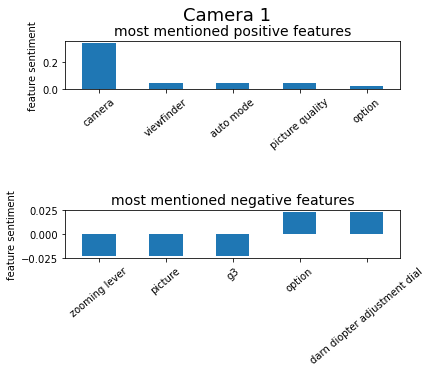

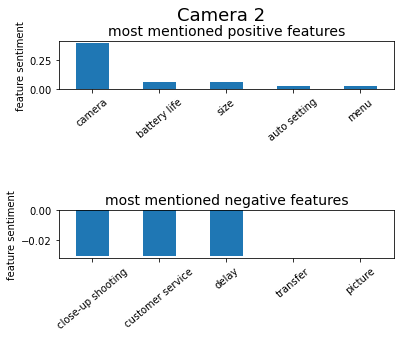

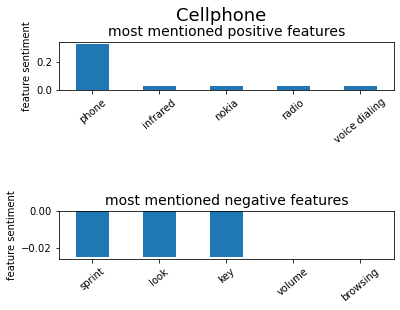

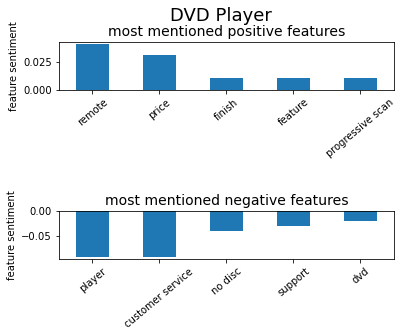

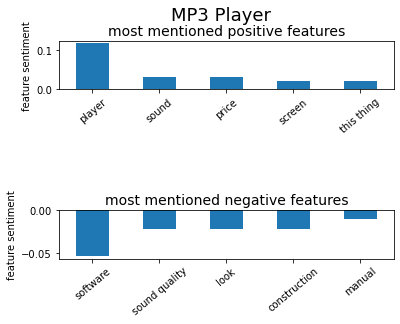

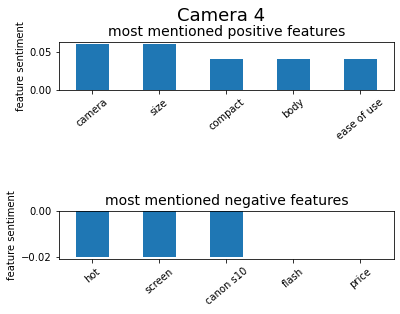

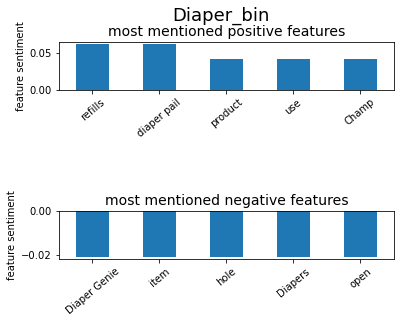

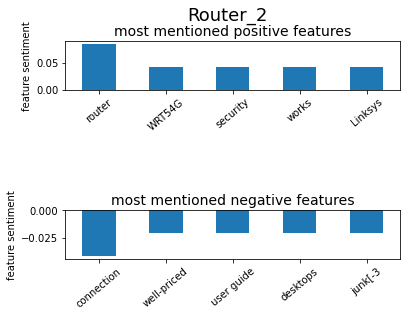

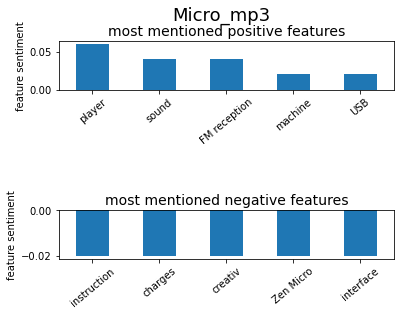

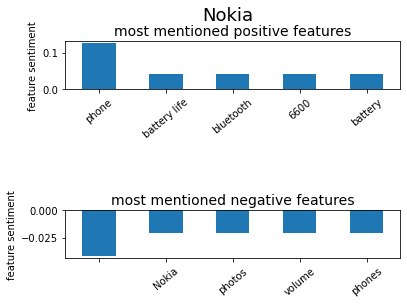

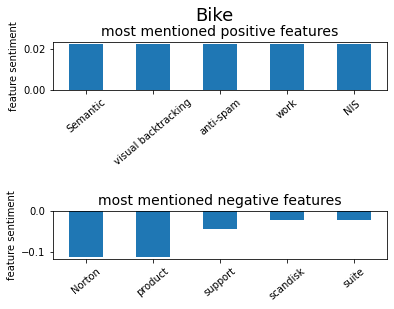

In [2]:
# Processes source txt files into pandas dataframes
def process_txt_to_df(file_name, product_name, title=True):
    with open(file_name, "r") as file:
        # Reads all lines from source data
        lines = file.readlines()
        
        # Deals with header lines
        if title == True:
            header_lines = 12
        else:
            header_lines = 1
        
        # Creates a df to save all reviews and map to the product features
        df_review = pd.DataFrame(columns=['title', 'full_text'])
        
        # Creates a df to save all review lines and map each line to product features
        df_line = pd.DataFrame(columns=['line_text'])
        
        # Saves text that maps to a feature in a review
        text_with_feature = ""
        
        # Saves review text and title 
        review_text = ""
        review_title = lines[header_lines]
        
        # Saves tuples of shape: (detected feature, score, commend)
        feature_scores = []
        
        # Variables used for indexing
        idx_review = 0
        idx_line = 0
        
        # Variable used for counting parsing failure 
        failed_lines = 0
        
        # Iterates through the review-lines, lines[:11] belongs to the header 
        for line in lines[header_lines:]:
            
            # Detects beginning of next review
            if "[t]" in line:
                # Saves title, text, detected features and scores of prior review
                df_review.at[idx_review, "title"] = review_title[3:-2]
                df_review.at[idx_review, "full_text"] = review_text
                final_score = 0
                for feature, score, commend in feature_scores:
                    final_score += score
                df_review.at[idx_review, feature] = np.sign(final_score)
        
                idx_review += 1
                
                # Resets the variables for the next review
                review_title = line
                text_with_feature = ""
                review_text = ""
                feature_scores = []
                
            # Detects lines without feature scores
            elif line[:2] == "##":
                review_text += line[2:-2]
                review_text += " "
                df_line.at[idx_line, "line_text"] = line[2:-2]
                idx_line += 1
            
            # Detects lines with feature scores
            else:
                try:
                    # Detects seperation index between features and review text to save review text
                    index = line.index("#")
                    review_text += line[index+2:-2]
                    review_text += " "
                    df_line.at[idx_line, "line_text"] = line[index+2:-2]
                    
                    # Extracts all features found
                    features = line[:index].split(",")
                    for feature in features:
                        feature = feature.strip()
                        
                        # Assesses if line about feature was POS or NEG
                        score = ""
                        if "+" in feature:
                            score = 1
                        else:
                            score = -1
                        
                        # Saves tuple with extracted data in feature_score
                        # populates df_line tuple with lines mapped to features
                        if "[u]" in feature:
                            feature_scores.append([feature[:-7], score, "[u]"])
                            df_line.at[idx_line, feature[:-7]] = str(score) + "[u]"
                        elif "[p]" in feature:
                            feature_scores.append([feature[:-7], score, "[p]"])
                            df_line.at[idx_line, feature[:-7]] = str(score) + "[p]"
                        elif "[s]" in feature:
                            feature_scores.append([feature[:-7], score, "[s]"])
                            df_line.at[idx_line, feature[:-7]] = str(score) + "[s]"
                        elif "[cc]" in feature:
                            feature_scores.append([feature[:-8], score, "[cc]"])
                            df_line.at[idx_line, feature[:-8]] = str(score) + "[cc]"
                        elif "[cs]" in feature:
                            feature_scores.append([feature[:-8], score, "[cs]"])
                            df_line.at[idx_line, feature[:-7]] = str(score) + "[cs]"
                        else:
                            feature_scores.append([feature[:-4], score, "[]"])
                            df_line.at[idx_line, feature[:-4]] = str(score)
                    idx_line += 1
                
                # Respective line could not be parsed
                except:
                    failed_lines += 1
        
        print(f"{product_name} data loading completed! \nParsing problems detected: {failed_lines}")
        
        # Creates a list of all detected features
        features = list(df_review.columns)
        features = features[2:]
        
        # Fills all NA values with 0 in the generated dataframes
        df_review.fillna(0, inplace=True)
        df_line.fillna(0, inplace=True)
        
        # Creates df with features and POS as well as NEG sentiment
        feature_df = pd.DataFrame(df_review[df_review.columns[2:]].mean(axis=0),
                                  columns=['feature_sentiments'])
        feature_df.index = features
        
        print(f"Number of features found:", len(features))
        print(f"Number of reviews analyzed: ", df_review.shape[0])
        print(f"Number of lines analyzed: ", df_line.shape[0])
        print()
        
        return df_review, df_line, feature_df


# Creates dataframes for all products
# Source data: Customer_review_data
cam_1_df, cam_1_line_df, cam_1_features = process_txt_to_df("Data/Customer_review_data/Canon G3.txt", "cam_1")
cam_2_df, cam_2_line_df, cam_2_features = process_txt_to_df("Data/Customer_review_data/Nikon coolpix 4300.txt", "cam_2")
cellphone_df, cellphone_line_df, cellphone_features = process_txt_to_df("Data/Customer_review_data/Nokia 6610.txt", "cellphone")
dvd_player_df, dvd_player_line_df, dvd_player_features = process_txt_to_df("Data/Customer_review_data/Apex AD2600 Progressive-scan DVD player.txt", "dvd_player")
mp3_player_df, mp3_player_line_df, mp3_player_features = process_txt_to_df("Data/Customer_review_data/Creative Labs Nomad Jukebox Zen Xtra 40GB.txt", "mp3_player")

# Source data: Reviews-9-products
# cam_3_df, cam_3_line_df, cam_3_features = process_txt_to_df("Data/Reviews-9-products/Canon PowerShot SD500.txt", 'cam_3', title=False)
cam_4_df, cam_4_line_df, cam_4_features = process_txt_to_df("Data/Reviews-9-products/Canon S100.txt", 'cam_4', title=False)
diaper_bin_df, diaper_bin_line_df, diaper_bin_features = process_txt_to_df("Data/Reviews-9-products/Diaper Champ.txt", 'diaper_bin', title=False)
router_1_df, router_1_line_df, router_1_features = process_txt_to_df("Data/Reviews-9-products/Hitachi router.txt", 'router_1', title=False)
# ipod_df, ipod_line_df, ipod_features = process_txt_to_df("Data/Reviews-9-products/ipod.txt", 'ipod', title=False)
router_2_df, router_2_line_df, router_2_features = process_txt_to_df("Data/Reviews-9-products/Linksys Router.txt", 'router_2', title=False)
micro_mp3_df, micro_mp3_line_df, micro_mp3_features = process_txt_to_df("Data/Reviews-9-products/MicroMP3.txt", 'micro_MP3', title=False)
nokia_df, nokia_line_df, nokia_features = process_txt_to_df("Data/Reviews-9-products/Nokia 6600.txt", 'nokia', title=False)
bike_df, bike_line_df, bike_features = process_txt_to_df("Data/Reviews-9-products/norton.txt", 'bike', title=False)

# Source data: CustomerReviews-3_domains
# computer_df, computer_line_df, computer_features = process_txt_to_df("Data/CustomerReviews-3_domains/Computer.txt", 'computer', title=False)
# router_3_df, router_3_line_df, router_3_features = process_txt_to_df("Data/CustomerReviews-3_domains/Router.txt", 'router_3', title=False)
# speaker_df, speaker_line_df, speaker_features = process_txt_to_df("Data/CustomerReviews-3_domains/Speaker.txt", 'speaker', title=False)



# Imports the pretrained "en_core_web_lg" model that can be used for NLP operations
nlp = spacy.load("en_core_web_lg")

def preprocess_text(product_df, product_line_df):
    # Tokenizes full review text, removes stopwords and punctuations
    tokenized_review = product_df['full_text'].apply(lambda x: [token for token in nlp(x) 
                                                                if not token.is_stop 
                                                                and token.is_alpha])
    
    # Saves tokens in product_df
    product_df['tokens'] = tokenized_review
    
    # Saves tokens as str
    product_df["processed_text"] = product_df['tokens'].apply(lambda x: " ".join([y.text for y in x]))
    
    # Tokenizes every line of every review, removes stopwords and punctuations
    tokenized_lines = product_line_df["line_text"].apply(lambda x: [token for token in nlp(x) 
                                                                    if not token.is_stop 
                                                                    and token.is_alpha])
    # Saves tokens in product_line_df
    product_line_df['tokens'] = tokenized_lines
    
    # Saves tokens as str
    product_line_df["processed_text"] = product_line_df['tokens'].apply(lambda x: " ".join([y.text for y in x]))
    
# Preprocesses all the df training data
i = 0
for (product_df, product_line_df) in [(cam_1_df, cam_1_line_df),
                                      (cam_2_df, cam_2_line_df),
                                      (cellphone_df, cellphone_line_df),
                                      (dvd_player_df, dvd_player_line_df),
                                      (mp3_player_df, mp3_player_line_df),
                                      (cam_4_df, cam_4_line_df),
                                      (diaper_bin_df, diaper_bin_line_df),
                                      (router_1_df, router_1_line_df),
                                      (router_2_df, router_2_line_df),
                                      (micro_mp3_df, micro_mp3_line_df),
                                      (nokia_df, nokia_line_df),
                                      (bike_df, bike_line_df)]:
    i += 1
    preprocess_text(product_df, product_line_df)
    print(f"preprocessing of dataframe {i} finished!")
    
    
def plot_feature_frequency(feature_df, name):
    fig, axes = plt.subplots(2)
    fig.subplots_adjust(hspace=2.5)
    fig.suptitle(name, fontsize=18,
                 y=1.)
    axes[0].set_title("most mentioned positive features", fontsize=14)
    axes[1].set_title("most mentioned negative features", fontsize=14)
    axes[0].set_ylabel("feature sentiment")
    axes[1].set_ylabel("feature sentiment")
    
    # Finds and plots the 5 features with the highest sentiment scores
    largest_5 = feature_df.nlargest(5, columns='feature_sentiments')
    largest_plot = largest_5.plot.bar(ax=axes[0], use_index=True, 
                                       y='feature_sentiments', rot=40,
                                       legend=False)
    
    # Finds and plots the 5 features with the lowest sentiment scores
    smallest_5 = feature_df.nsmallest(5, columns='feature_sentiments')
    smallest_plot = smallest_5.plot.bar(ax=axes[1], use_index=True, 
                                         y='feature_sentiments', rot=40,
                                         legend=False)


product_list = [(cam_1_features, "Camera 1"),
                (cam_2_features, "Camera 2"),
                (cellphone_features, "Cellphone"),
                (dvd_player_features, "DVD Player"),
                (mp3_player_features, "MP3 Player"),
                (cam_4_features, "Camera 4"),
                (diaper_bin_features, "Diaper_bin"),
                (router_2_features, "Router_2"),
                (micro_mp3_features, "Micro_mp3"),
                (nokia_features, "Nokia"),
                (bike_features, "Bike")]

for product, name in product_list:
    plot_feature_frequency(product, name)

## Product Feature Extraction

To perform the product feature extraction, the frequency counts and pointwise mutual information were used. The product feature extraction task was identified to have two contradictory goals. First the algorithm should find as many “true” product features as possible, therefore achieving high recall. But the algorithm should also not identify meaningless words as product features, which can be translated into having a high precision. Whether precision or recall should be weighted more heavily depends on the opinion miner user preference. The frequency counts algorithm was chosen for this task because it is believed to achieve higher scores on the precision metrics while probably scoring lower on the recall metrics. The pointwise mutual information was believed to achieve high recall scores but to score lower on the precision metrics. Therefore the algorithms are suitable for a comparative study.<br>

Before any of the two algorithms was deployed, the review dataset was tokenized, and POS tagging was performed (How these steps work was discussed in the “data preprocessing” section). The POS tag associated with every token in the dataset was then used to filter out all tokens, which are not nouns or are not the subject or an object in the sentence. It was discovered that this prefiltering step increased the performance of both algorithms used.<br>

The frequency counts algorithm was then deployed on this token collection to determine which monograms, bigrams (two-word snippets) or trigrams (three-word snippets) where the most frequent in the text. If any of the grams was more frequent than a certain threshold, than the gram was added to the set of extracted features (see <strong>Figure 4.</strong>). The thresholds that achieved the highest performance were determined by testing different threshholds for the highest F1-score performance on one product dataset. Monograms that also appeared in bi- or trigrams were removed from the resulting feature list. Pointwise mutual information (PMI) does also consider the frequency of bi- and trigrams to find meaningful product features. But this algorithm additionally divides these frequencies by the monomer frequencies and uses logarithmic values (see <strong>Figure 4.</strong>). This has the effect that if one or both of the monograms are low frequency words in the word corpus analyzed the pointwise mutual information score of the bigrams will be considerably higher compared to the frequency counts approach. This algorithm is therefore more suited to find “rare” product features compared to the frequency counts algorithm, which is the reason why it is believed to have a higher resulting recall. For this algorithm too, grams with higher PMI score than a predefined threshold were added to the resulting feature list. Monograms that also appeared in bi- or trigrams were removed from the resulting feature list.



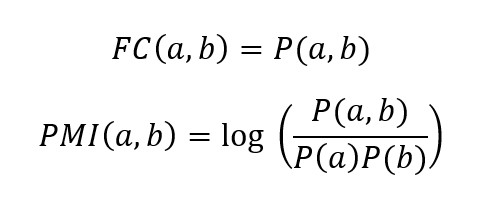
<p style="text-align: justify"><font size='2'>
<strong>Figure 4</strong>: <i>Illustration showing how the frequency counts (upper equation) and pointwise mutual infromation (lower equation) scores are calculated for bigrams. The same logic can be applied to obtain trigram scores. P(a) and P(b) stands for the probability to see word a or b inside the word corpus, while P(a, b) stands for the probability to see both words next to each other in the text.<sup>4</sup></i></font></p>

Code Sources:<sup>[3-7]</sup>

In [3]:
# Creates bigrams and trigrams based on frequency counts
def frequency_counts(product_df, param1, param2, param3, param4):
    
    # Used to save the extracted features
    extracted_features_1 = []
    extracted_features_2 = []
    
    # Removes tokens that are not nouns and subjects or objects of the sentence
    tokens = [token.lemma_ for line in product_df['tokens'] for token in line
              if token.pos_ == "NOUN" and (token.dep_ == "nsubj" or token.dep_ == "dobj")]
    
    # Creates a token frequency distribution
    token_fd = nltk.FreqDist(tokens)
    
    # Creates a bigram and trigram frequency distribution
    token_bigram_fd = nltk.FreqDist(nltk.bigrams(tokens))
    token_trigram_fd = nltk.FreqDist(nltk.trigrams(tokens))
    
    
    # Adds tokens to feature list, if the frequency score is higher than cut-off value
    for token, score in token_fd.most_common(param4):
        if score >= param1:
            extracted_features_1.append(token)
            extracted_features_2.append(token)
            

    # Used to remove tokens that also appear in bigrams or trigrams
    words_to_be_removed = []
    
    # Adds bigrams to feature list, if the frequency score is higher than cut-off value
    for (word1, word2), score in token_bigram_fd.most_common(param4):
        if score >= param2:
            if all(word in extracted_features_1 for word in (word1, word2)) and word1 != word2:
                compound_word = " ".join([word1, word2])
                extracted_features_1.append(compound_word)
                
                # Removes tokens included in bigram from feature list
                words_to_be_removed.extend([word1, word2])
    
    # Adds trigrams to feature list, if the frequency score is higher than cut-off value
    for (word1, word2, word3), score in token_trigram_fd.most_common(param4):
        if score >= param3:
            if all(word in extracted_features_1 for word in (word1, word2, word2)) and word1 != word2 != word3:
                compound_word = " ".join([word1, word2, word3])
                extracted_features_1.append(compound_word)
                
                # Removes bigrams included in trigram from feature list
                sub1_compound_word = " ".join([word1, word2])
                sub2_compound_word = " ".join([word2, word3])
                if sub1_compound_word in extracted_features_1:
                    words_to_be_removed.append(sub1_compound_word)
                if sub2_compound_word in extracted_features_1:
                    words_to_be_removed.append(sub2_compound_word)
                words_to_be_removed.extend([word1, word2, word3])    
     
    # Removes all duplicated features
    for word in set(words_to_be_removed):
        if word in extracted_features_1:
            extracted_features_1.remove(word)
    
    return tokens, extracted_features_1, extracted_features_2


# Creates bigrams and trigrams based on pointwise mutual information
def pointwise_mutual_information(product_df, extracted_features_2, param5, param6, tokens):
    
    # Used to remove tokens that also appear in bigrams or trigrams
    words_to_be_removed = []
    
    # NLTK library used to determine PMI scores of bigrams
    finder = BigramCollocationFinder.from_words(tokens)
    bigram_measures = BigramAssocMeasures()
    
    # Adds bigrams to feature list, if the PMI score is higher than cut-off value
    for (word1, word2), pmi_score in finder.score_ngrams(bigram_measures.pmi):
        if pmi_score >= param5:
            if all(word in extracted_features_2 for word in (word1, word2)) and word1 != word2:
                if not " ".join([word2, word1]) in extracted_features_2:
                    compound_word = " ".join([word1, word2])
                    extracted_features_2.append(compound_word)
                    
                    # Removes tokens included in bigram from feature list
                    words_to_be_removed.extend([word1, word2])
    
    # NLTK library used to determine PMI scores of trigrams
    finder = TrigramCollocationFinder.from_words(tokens)
    trigram_measures = TrigramAssocMeasures()
    
    # Adds trigrams to feature list, if the frequency score is higher than cut-off value
    for (word1, word2, word3), pmi_score in finder.score_ngrams(trigram_measures.pmi):
        if pmi_score >= param6:
            if all(word in extracted_features_2 for word in (word1, word2, word2)) and word1 != word2 != word3:
                compound_word = " ".join([word1, word2, word3])
                extracted_features_2.append(compound_word)
                
                # Removes bigrams included in trigram from feature list
                sub1_compound_word = " ".join([word1, word2])
                sub2_compound_word = " ".join([word2, word3])
                if sub1_compound_word in extracted_features_2:
                    words_to_be_removed.append(sub1_compound_word)
                if sub2_compound_word in extracted_features_2:
                    words_to_be_removed.append(sub2_compound_word)
                words_to_be_removed.extend([word1, word2, word3])
                
                
    # Removes all duplicated features
    for word in set(words_to_be_removed):
        if word in extracted_features_2:
            extracted_features_2.remove(word)
            
    return extracted_features_2



# Extracts the product features by using frequency counts and pointwise mutual information (PMI)
def feature_extraction(product_df, param_1, param_2, param_3, param_4, param_5, param_6):
    
    # Performs frequency counts analysis
    tokens, extracted_features_1, extracted_features_2 = frequency_counts(product_df, param_1, param_2, param_3, param_4)
    
    # Performs pointwise mutual information analysis
    extracted_features_2 = pointwise_mutual_information(product_df, extracted_features_2, param_5, param_6, tokens)

    return extracted_features_1, extracted_features_2
    
    
# Runs feature extraction for all products
extracted_features = {}
i = 0
for product_df, df_name, df_feature in [(cam_1_df, "cam_1_df", cam_1_features), (cam_2_df, "cam_2_df", cam_2_features),
                                        (cellphone_df, "cellphone_df", cellphone_features), 
                                        (dvd_player_df, "dvd_player_df", dvd_player_features),
                                        (mp3_player_df, "mp3_player_df", mp3_player_features), (cam_4_df, "cam_4_df", cam_4_features),
                                        (diaper_bin_df, "diaper_bin_df", diaper_bin_features), 
                                        (router_1_df, "router_1_df", router_1_features),
                                        (router_2_df, "router_2_df", router_2_features), 
                                        (micro_mp3_df, "micro_mp3_df", micro_mp3_features), 
                                        (nokia_df, "nokia_df", nokia_features), (bike_df, "bike_df", bike_features)]:
    true_feature = df_feature.index
    extracted_features_1, extracted_features_2 = feature_extraction(product_df, 6, 7, 4, 500, 10, 20)
    extracted_features[df_name] = [extracted_features_1, extracted_features_2, list(true_feature)]
    i += 1
    print(f"Feature extraction of dataframe {i} finished!")
print("Feature extraction finished!")

        
# extracted_features_1, extracted_features_2 = feature_extraction(mp3_player_df, 6, 7, 4, 500, 10, 20)
# true_features = mp3_player_features.index



# Calculates the f1_scores for the extracted features
def f1_score(extracted_features, true_features):
    # Converts lists to sets
    extracted_features = set(extracted_features)
    true_features = set(true_features)
    
    # Calculates the Recall, Precision and F1 Scores
    true_pos = len(extracted_features.intersection(true_features))
    false_pos = len(extracted_features) - true_pos
    false_neg = len(true_features) - true_pos
    
    recall = true_pos / (true_pos + false_neg)
    precision = true_pos / (true_pos + false_pos)
    
    if recall + precision != 0:
        f1_score = 2 * (recall * precision) / (recall + precision)
    else:
        f1_score = 0
    
    return f1_score


grid_search = False
# Performs grid search to find the best hyperparameters
if grid_search==True:
    
    # Predetermined features for mp3_player
    true_features = mp3_player_features.index

    # Grid search for the frequency counts feature extraction
    max_f1 = 0
    grid_search_1 = False
    if grid_search_1 == True:
        for x in [1, 2, 3, 4, 5, 6, 7]:
            for y in [1, 2, 3, 4, 5, 6, 7]:
                for z in [1, 2, 3, 4, 5, 6, 7]:
                    for p in [500, 1000, 1500, 2000, 5000]:
                        extracted_features_1, extracted_features_2 = feature_extraction(mp3_player_df, x, y, z, p, 1, 1)
                        current_f1_score = f1_score(extracted_features_1, true_features)
                        if current_f1_score > max_f1:
                            max_f1 = current_f1_score
                            best_param = [x, y, z, p]
        print(max_f1)
        print(best_param)
    
    # Grid search for the PMI feature extraction
    max_f1 = 0
    best_param = []
    grid_search_2 = False
    if grid_search_2 == True:
        for x in [0.1, 0.25, 0.5, 0.75, 1, 1.25, 5, 10, 12, 15, 20, 50]:
            for y in [10, 20, 30, 40, 50]:
                for p in [500, 1000, 1500, 2000, 2500, 5000]:
                    extracted_features_1, extracted_features_2 = feature_extraction(mp3_player_df, 6, 7, 4, p, x, y)
                    current_f1_score = f1_score(extracted_features_2, true_features)
                    if current_f1_score > max_f1:
                        max_f1 = current_f1_score
                        best_param = [x, y, p]
        print(max_f1)
        print(best_param)               
                            


Feature extraction of dataframe 1 finished!
Feature extraction of dataframe 2 finished!
Feature extraction of dataframe 3 finished!
Feature extraction of dataframe 4 finished!
Feature extraction of dataframe 5 finished!
Feature extraction of dataframe 6 finished!
Feature extraction of dataframe 7 finished!
Feature extraction of dataframe 8 finished!
Feature extraction of dataframe 9 finished!
Feature extraction of dataframe 10 finished!
Feature extraction of dataframe 11 finished!
Feature extraction of dataframe 12 finished!
Feature extraction finished!


## Sentiment Analysis

The sentiment analysis part of the sentiment miner project was performed using two completely different approaches. The task was solved by building a linear support vector machine and by utilizing sentiment lexicons to analyze the sentences. The comparison between the machine learning approach and the sentiment lexicon approach was conducted, because there are significant pros and cons to both approaches, which differ from each other, as can be seen in <strong>Figure 5</strong>. The sentiment dictionary based approach can be applied by using pretrained models, which makes the collection of huge datasets for training unnecessary. Additionally in the VADER model used, grammatical rules are deployed to analyze the sentiment based on the word sequence and position. The linear support vector machine approach is of interest, because it can learn training data specific aspects while having a sufficiently fast runtime. This type of algorithm was also shown to perform strongly on classification tasks, as discussed in the lecture and is therefore suited in distinguishing between sentences with negative and positive sentiment.


<div>
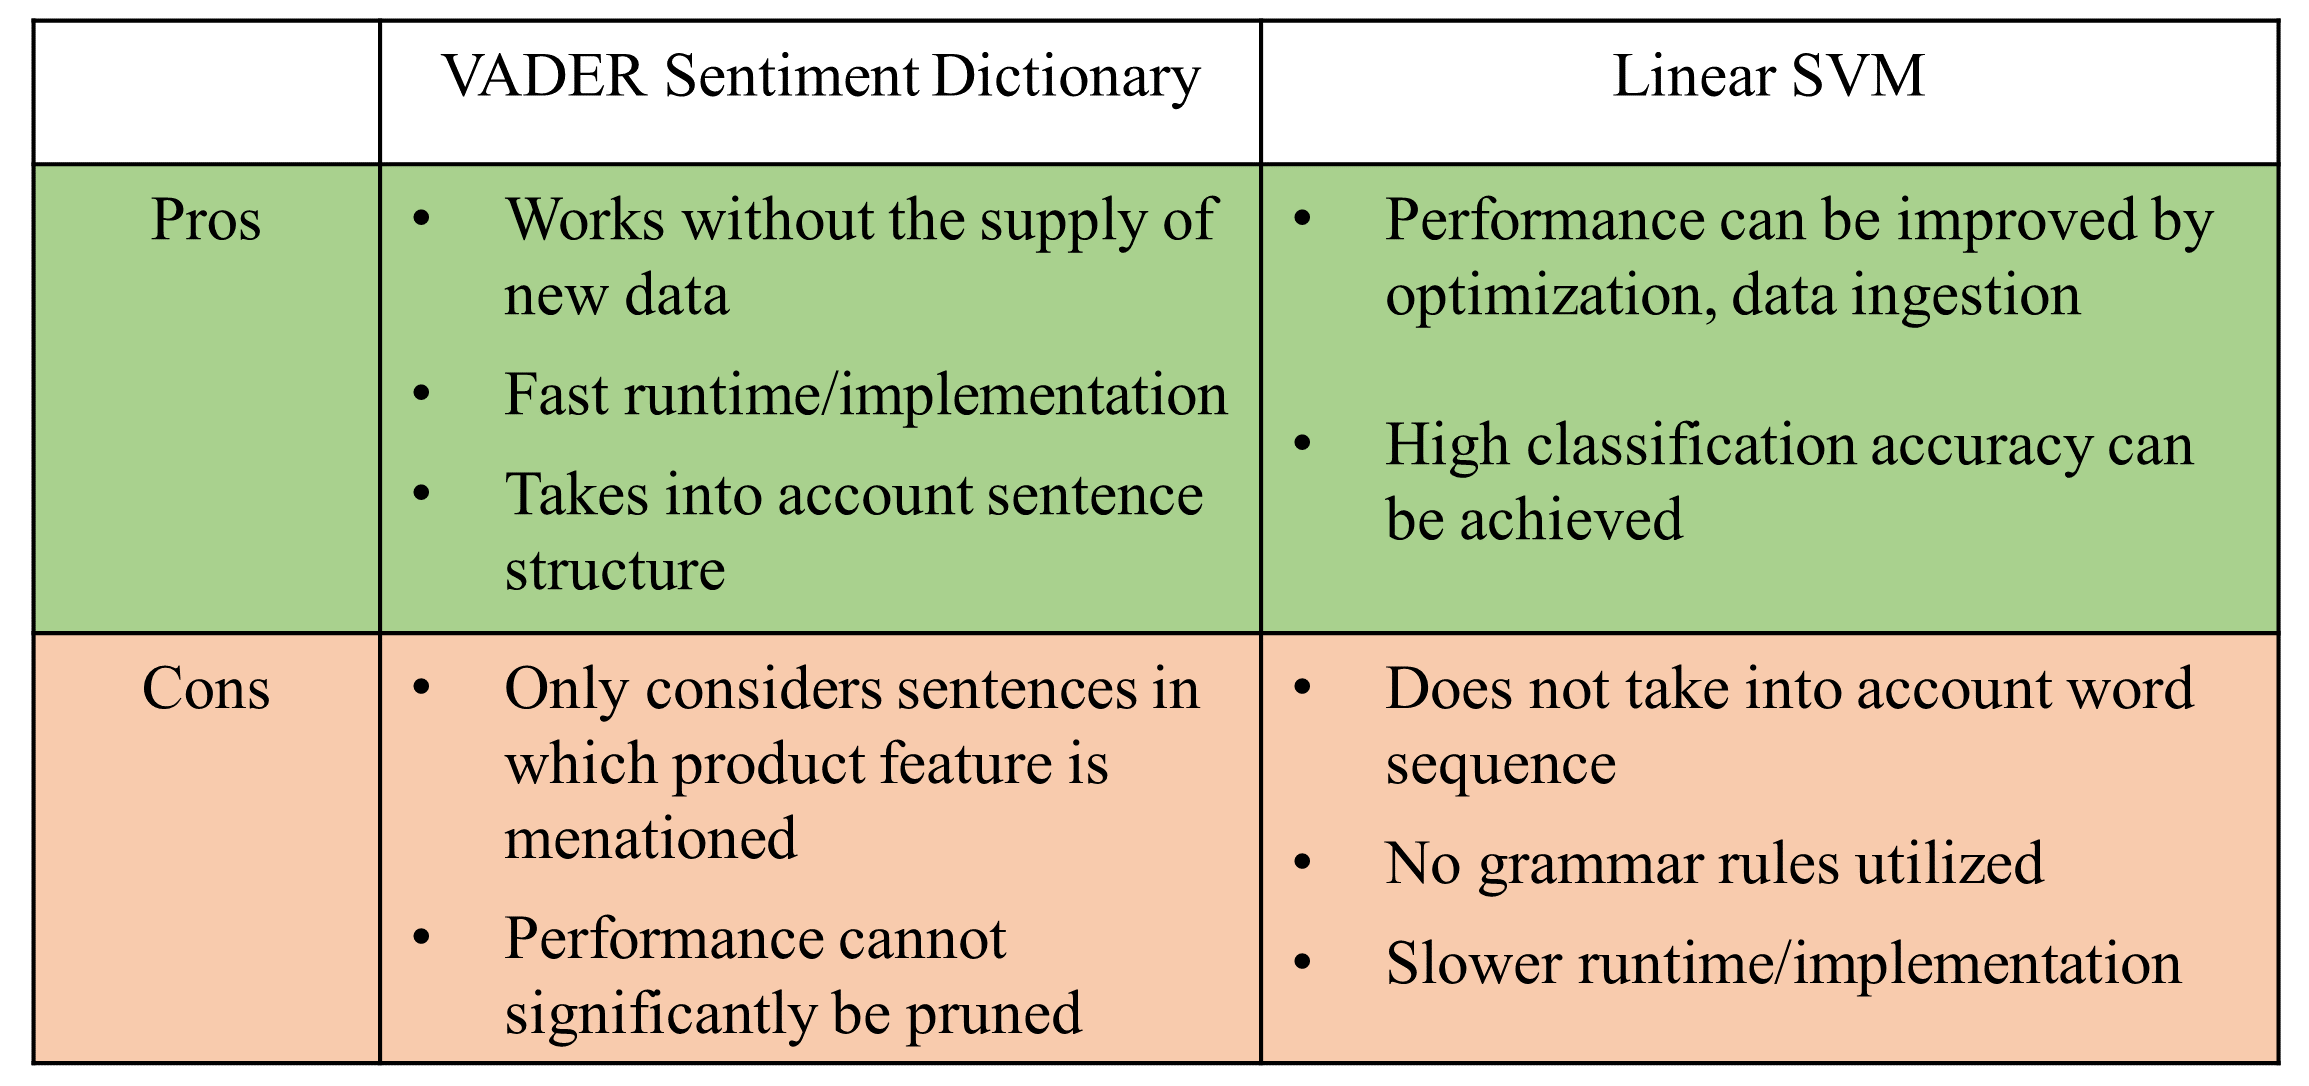
</div>
<p style="text-align: justify"><font size='2'>
<strong>Figure 5</strong>: <i>Extensive discussion of the Pros and Cons of both implemented algorithms for sentiment analysis.</i></font></p>

The linear support vector machine was built by splitting up the product reviews into training and testing data. The reviews were then processed into a bag-of-words representation by performing tf-idf vectorization using the sklearn library.<sup>[7]</sup> The tf-idf algorithm in this task works by first counting all the words in the individual reviews for one product and in all the reviews concerning one product. Based on these counts the term frequency (tf) can be calculated as a fraction of the word count in a review against the word count in the whole document. The inverse document frequency can be calculated by determining the logarithm of the frequency of a word over a range of documents (supplied by the sklearn library) over the frequency of the term in the product review dataset. Combining the term frequency and inverse document frequency then yields a final score for every word in the dataset. In this final score rare words are significantly boosted as a consequence of the idf part of the algorithm. The bag of words representation is then mapped to the prelabeled sentiment scores for every individual product review to supply the linear support vector machine with labelled training data. Linear support vector machines work by maximizing the distance of the datapoints to the decision boundary. Because outliers can strongly interfere with this maximization goal, the algorithm was trained using the Huber loss, which can deal more robustly with outliers compared to other loss functions (e.g. mean squared error). Sentiment predictions were than saved for evaluation purposes.

The second approach used a sentiment lexicon provided by NLTK called VADER to determine the sentiment scores.<sup>[6, 8]</sup> For this approach, first all the sentences contained in a review were split into subsentences based on punctuations after which stopwords were removed from the data set. Than all subsentences containing a target product feature were identified and the VADER algorithm was run on these subsentences to determine their sentiment. The sentiment of a review was concluded by determining the average sentiment of all subsentences found by above approach. The VADER algorithm works by utilizing a sentiment lexicon and syntactic rules for sentiment mapping. The sentiment lexicon maps words and word combination to specific sentiment scores while the syntactic rule protocol combines and refines these based on the grammatical structure of the analyzed sentence to give a final sentiment score, which is split into a neutral, positive and negative component.<sup>[8]</sup>  The results for this approach were again saved for evaluation purposes.


Code Sources:<sup>[3-8]</sup>

In [4]:
# Implements sentiment analysis using linear support vector machines (SVM)
def svm_sent_analysis(product_df, product_feature_df):

    # Performs tf_idf vectorization with the review text, removes stopwords
    X = product_df['full_text']
    tf_idf = TfidfVectorizer(use_idf=True, stop_words='english')
    X_idf = tf_idf.fit_transform(X)
    
    # Iterates through every preidentified product feature
    for feature in product_feature_df.index:
        y = product_df[feature]
        results = []
        
        # Runs 20 prediction rounds 
        # (needed to evaluate predictions, because data is extremly sparce)
        for _ in range(20):
            
            # Splits up data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X_idf, y, test_size=0.1,
                                                                shuffle=True)
            # Implements the hinge loss for the SVM model
            cls = SGDClassifier(loss='hinge')
            # Only fits the model if there is variability in the data set
            numb_classes = np.unique(y_train).shape[0]
            if not numb_classes == 1:
                cls.fit(X_train, y_train)
                y_pred = cls.predict(X_test)
                results.append(np.mean(y_pred))
            
            # Executed if all data points are inside one class (no class variability)
            #else:
             #   results.append(np.mean(y_train))
        
        # Saves the means prediction results for every feature
        if len(results) != 0:
            product_feature_df.at[feature, 'feature_sent_pred2'] = np.mean(results)
        else:
            product_feature_df.at[feature, 'feature_sent_pred2'] = 0

# Implements sentiment analysis using a sentiment lexicon        
def word_lexicon_sent_analysis(product_df, product_feature_df):
    
    # Imports NLTK's VADER model
    sentiment_analyser = SentimentIntensityAnalyzer()
    
    # Iterates through every preidentified product feature
    for feature in list(product_feature_df.index):
        
        # Saves the sentiment score of every review
        review_sent = []
        
        # Iterates through all reviews
        for review in product_df['full_text']:
            
            # Saves the positive and negative sentiments detected in subsentences of the review
            pos_sent_score = 0
            neg_sent_score = 0
            
            # Splits of subsentences
            for subsentence in re.split(";|\.|\,", str(review)):
                
                # Continues if the feature is found in the subsentence
                if feature in subsentence:
                    
                    # Tokenizes the subsentence and removes stopwords/punctuations
                    subsentence = [token.text for token in nlp(subsentence) 
                                   if not token.is_stop
                                   and token.is_alpha]
                    subsentence = " ".join(subsentence)
                    
                    # Determines the POS, NEG, NEU sentiment scores of the subsentence using VADER
                    sentiment = sentiment_analyser.polarity_scores(subsentence)
                    
                    # Accredites a poitive or negative sentiment score to the subsentence
                    if sentiment['neu'] < 8.0:
                        if sentiment['neg'] > sentiment['pos']:
                            neg_sent_score += 1
                        elif sentiment['pos'] > sentiment['neg']:
                            pos_sent_score += 1
            
            # Determines and saves the review sentiment
            review_sent_score = np.sign(pos_sent_score - neg_sent_score)
            review_sent.append(review_sent_score)
        
        # Determines and saves the total feature sentiment
        product_feature_df.at[feature, 'feature_sent_pred1'] = np.mean(review_sent)
        

# Runs both sentiment algorithms over the dataset
def sent_analysis(product_df, product_feature_df):
    product_feature_df['feature_sent_pred1'] = np.nan
    product_feature_df['feature_sent_pred2'] = np.nan
    
    svm_sent_analysis(product_df, product_feature_df)
    word_lexicon_sent_analysis(product_df, product_feature_df)
    
    
# Performs the sentiment analysis for all products/product features
i = 0    
for product_df, product_feature_df  in [(cam_1_df, cam_1_features),
                                        (cam_2_df, cam_2_features),
                                        (cellphone_df, cellphone_features),
                                        (dvd_player_df, dvd_player_features),
                                        (mp3_player_df, mp3_player_features),
                                        (cam_4_df, cam_4_features),
                                        (diaper_bin_df, diaper_bin_features),
                                        (router_1_df, router_1_features),
                                        (router_2_df, router_2_features),
                                        (micro_mp3_df, micro_mp3_features),
                                        (nokia_df, nokia_features),
                                        (bike_df, bike_features)]:
    sent_analysis(product_df, product_feature_df)
    i += 1
    print(f"Sentiment analysis of dataframe {i} finished!")
print("Sentiment analysis finished!")

Sentiment analysis of dataframe 1 finished!
Sentiment analysis of dataframe 2 finished!
Sentiment analysis of dataframe 3 finished!
Sentiment analysis of dataframe 4 finished!
Sentiment analysis of dataframe 5 finished!
Sentiment analysis of dataframe 6 finished!
Sentiment analysis of dataframe 7 finished!
Sentiment analysis of dataframe 8 finished!
Sentiment analysis of dataframe 9 finished!
Sentiment analysis of dataframe 10 finished!
Sentiment analysis of dataframe 11 finished!
Sentiment analysis of dataframe 12 finished!
Sentiment analysis finished!


## Evaluation and Discussion

To analyze the performance of the feature extraction algorithm, the recall, precision as well as the F1-scores over all the products of both the frequency counts and PMI algorithm were considered (see <strong>Figure 6</strong>). The pointwise mutual information approach achieved higher average recall scores just as expected due to the algorithms ability to identify rarer features compared to the frequency counts approach. The algorithm also achieved higher average precision scores probably due to its ability to discriminate against very frequent bigrams and trigrams. This concludes it to be the superior option over the frequency counts algorithm for feature extraction. <br>
The performance of the sentiment analysis algorithms was measured by calculating the mean squared error value between the predicted sentiment score and the real sentiment values (see <strong>Figure 6</strong>). Even though the linear support vector machine performed considerable better on this metric, it was found out after further investigation on why this was the case, that due to the extreme sparsity of the data, the linear SVM close to always predicted a sentiment score of zero. Therefore the sentiment dictionary algorithm was determined to be superior, because it was pretrained on a much bigger dataset. The SVM algorithm could be made viable after considerable data ingestion into the system. The performance of the sentiment analysis algorithm could further be increased by identifying sentences that talk about a specific features, but do not mention it directly, a major downside of the currently implemented approach. <br>
The performance of the opinion miner could further be improved by implementing recurrent learning and asking the users to rate the usefulness of identified product features. User ranking data could be used boost the performance by means of data ingestion and to implement feature extraction algorithms that not only consider word frequencies, but also implement complex grammatical rules to extract the most important bits of information contained in the text. The overall performance of the opinion miner could be measured by again using user data (e.g. users could be asked if the opinion miner helped them find a product) or the metrics of both sub algorithms could be combined to obtain one metric for the entire system.


<div>
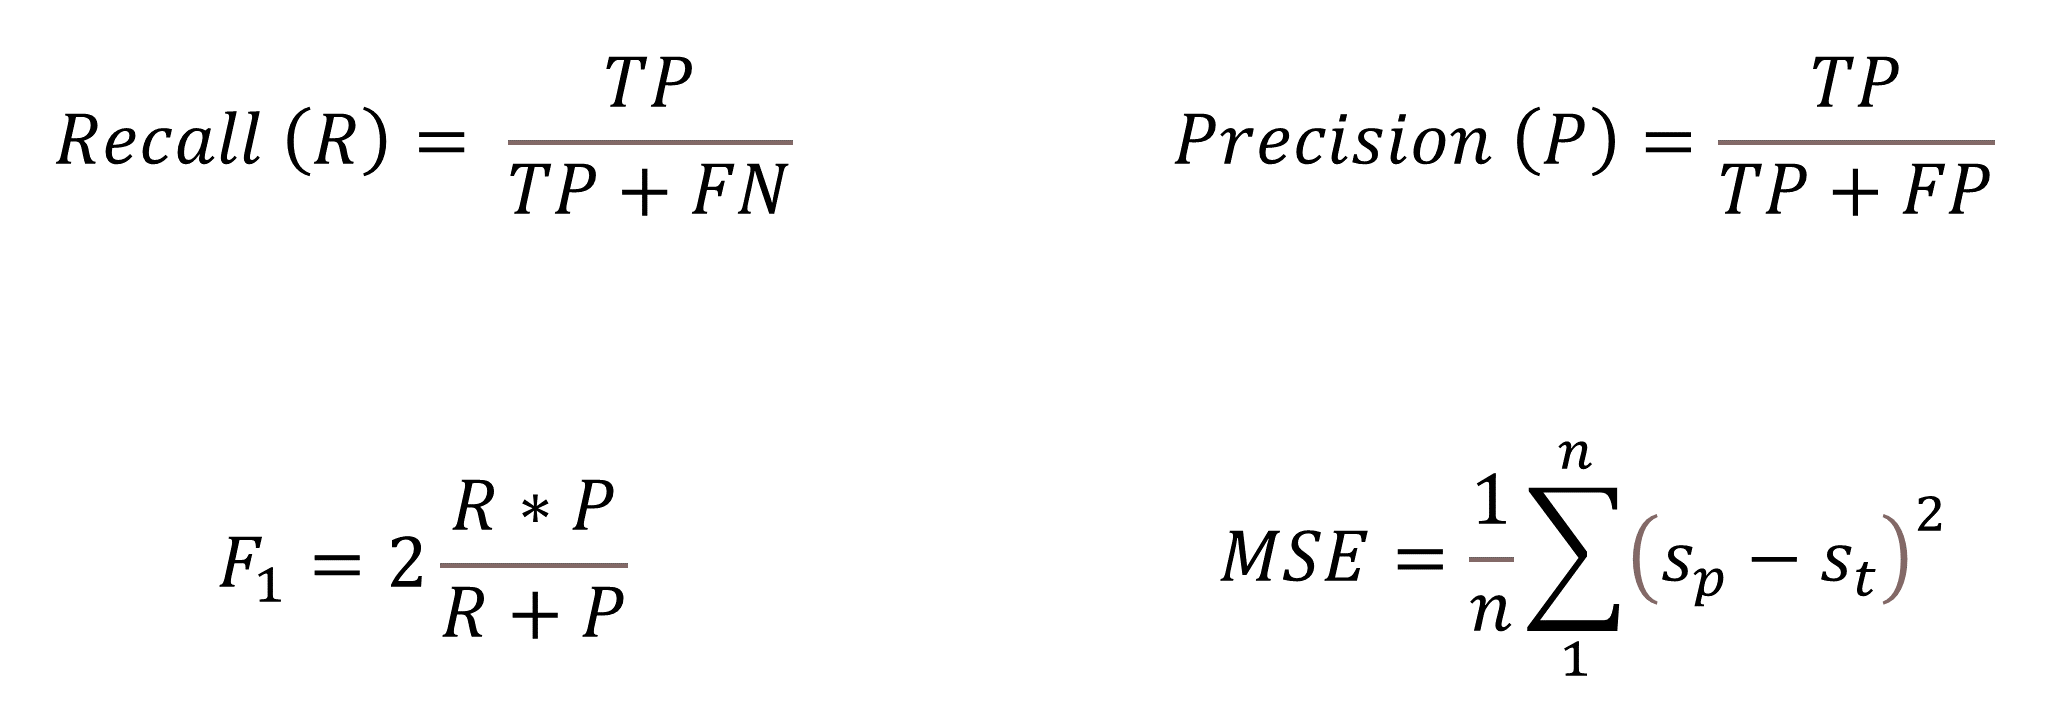
</div>
<p style="text-align: justify"><font size='2'>
<strong>Figure 6</strong>: <i>Illustration of the formulas used to calculate Recall, Precision, F1-Score and MSE as discussed in the lectures. TP stands for true positives and corresponds to the actual product features, which were correctly identified by the feature extraction algorithms. FP stands for false positives and corresponds to identified features that were not actual product features. FN stands for actual product features, that were not identified. Sp and St stand for the predicted and actual sentiment scores.</i></font></p>

Code Sources:<sup>[3-7]</sup>

In [5]:
# Calculates the performance metrics for the extracted features

def performance_metrics(all_features):
    # Converts lists to sets
    extracted_features_1 = set(all_features[0])
    extracted_features_2 = set(all_features[1])
    true_features = set(all_features[2])
    
    # Calculates the Recall, Precision and F1 Scores for feature extraction algorithm 1
    true_pos_1 = len(extracted_features_1.intersection(true_features))
    false_pos_1 = len(extracted_features_1) - true_pos_1
    false_neg_1 = len(true_features) - true_pos_1
    
    recall_1 = true_pos_1 / (true_pos_1 + false_neg_1)
    precision_1 = true_pos_1 / (true_pos_1 + false_pos_1)
    
    if recall_1 + precision_1 != 0:
        f1_score_1 = 2 * (recall_1 * precision_1) / (recall_1 + precision_1)
    else:
        f1_score_1 = 0
        
        
    # Calculates the recall, precision and F1 scores for feature extraction algorithm 2
    true_pos_2 = len(extracted_features_2.intersection(true_features))
    false_pos_2 = len(extracted_features_2) - true_pos_2
    false_neg_2 = len(true_features) - true_pos_2
    
    recall_2 = true_pos_2 / (true_pos_2 + false_neg_2)
    precision_2 = true_pos_2 / (true_pos_2 + false_pos_2)
    
    if recall_2 + precision_2 != 0:
        f1_score_2 = 2 * (recall_2 * precision_2) / (recall_2 + precision_2)
    else:
        f1_score_2 = 0
    
    return [precision_1, recall_1, f1_score_1, precision_2, recall_2, f1_score_2]


feature_extraction_performance = pd.DataFrame(columns=[["Frequency Counts", "Frequency Counts", "Frequency Counts", 
                                                        "PMI", "PMI", "PMI"],
                                                       ["precision", "recall", "f1", "precision", "recall", "f1"]])

for i, product_feature in enumerate(extracted_features):
    results = performance_metrics(extracted_features[product_feature])
    feature_extraction_performance.loc[i, :] = results

feature_extraction_performance.index.name = "Products"


print("\nFeature extraction performance results:\n")
print(feature_extraction_performance)
print("\nMean feature extraction performance results:\n")
print(feature_extraction_performance.mean())
print("\nMax feature extraction performance results:\n")
print(feature_extraction_performance.max())
print("\nMin feature extraction performance results:\n")
print(feature_extraction_performance.min())


Feature extraction performance results:

         Frequency Counts                           PMI                    
                precision    recall        f1 precision    recall        f1
Products                                                                   
0                0.269231  0.318182  0.291667  0.269231  0.318182  0.291667
1                0.142857     0.125  0.133333  0.142857     0.125  0.133333
2                0.055556  0.045455      0.05  0.166667  0.136364      0.15
3                0.347826       0.2  0.253968  0.347826       0.2  0.253968
4                0.276923  0.391304  0.324324  0.287879  0.413043  0.339286
5                    0.25  0.068966  0.108108  0.333333  0.103448  0.157895
6                0.363636  0.142857  0.205128  0.416667  0.178571      0.25
7                0.285714  0.142857  0.190476  0.285714  0.142857  0.190476
8                0.296296  0.235294  0.262295  0.296296  0.235294  0.262295
9                   0.125  0.129032  0.126984 

In [6]:
# Calculates the performance metrics for the sentiment analysis


sentiment_analysis_performance = pd.DataFrame(columns=[["Sentiment Dictionary (VADER)", "Support Vector Machine"],
                                                       ["Mean Squared Error", "Mean Squared Error"]])


for i, product_feature_df in enumerate([cam_1_features, cam_2_features,
                                        cellphone_features, dvd_player_features,
                                        mp3_player_features, cam_4_features,
                                        diaper_bin_features, router_1_features,
                                        router_2_features, micro_mp3_features,
                                        nokia_features, bike_features]):

    MSE_sent_1 = mean_squared_error(product_feature_df['feature_sentiments'],
                                    product_feature_df['feature_sent_pred1'])
    MSE_sent_2 = mean_squared_error(product_feature_df['feature_sentiments'],
                                    product_feature_df['feature_sent_pred2'])
    
    sentiment_analysis_performance.loc[i] = MSE_sent_1, MSE_sent_2
    

print("\nSentiment analysis performance results:\n")
print(sentiment_analysis_performance)
print("\nMean Sentiment analysis performance results:\n")
print(sentiment_analysis_performance.mean())
print("\nMax Sentiment analysis performance results:\n")
print(sentiment_analysis_performance.min())
print("\nMin Sentiment analysis performance results:\n")
print(sentiment_analysis_performance.max())


Sentiment analysis performance results:

   Sentiment Dictionary (VADER) Support Vector Machine
             Mean Squared Error     Mean Squared Error
0                      0.029278               0.002923
1                      0.019685               0.003754
2                      0.033636               0.002570
3                      0.021033               0.000307
4                      0.021722               0.000488
5                      0.009393               0.000451
6                      0.036815               0.000818
7                      0.030397               0.007174
8                      0.016963               0.000632
9                      0.029584               0.000498
10                     0.046914               0.001395
11                     0.007796               0.000980

Mean Sentiment analysis performance results:

Sentiment Dictionary (VADER)  Mean Squared Error    0.025268
Support Vector Machine        Mean Squared Error    0.001833
dtype: float64

Max

In [7]:
# Final System Output DVD Player

# Performs Feature Extraction
_, extracted_features_2 = feature_extraction(dvd_player_df, 6, 7, 4, 500, 10, 20)
feature_df = pd.DataFrame(index=extracted_features_2)

# Performs Sentiment Analysis
word_lexicon_sent_analysis(dvd_player_df, feature_df)

# Prints out the results of the final model:
print("Product: DVD Player")
for i, index in enumerate(feature_df.index):
    print(f"\tProduct feature {i+1}: {index}")
    print("\t\tSentiment Score:", int(feature_df["feature_sent_pred1"][index] * len(dvd_player_df)))
    print()

Product: DVD Player
	Product feature 1: player
		Sentiment Score: 30

	Product feature 2: problem
		Sentiment Score: -20

	Product feature 3: apex
		Sentiment Score: 7

	Product feature 4: disc
		Sentiment Score: 3

	Product feature 5: picture
		Sentiment Score: 10

	Product feature 6: unit
		Sentiment Score: 3

	Product feature 7: thing
		Sentiment Score: 15

	Product feature 8: button
		Sentiment Score: -1

	Product feature 9: review
		Sentiment Score: 7

	Product feature 10: t
		Sentiment Score: 51

	Product feature 11: feature
		Sentiment Score: 15

	Product feature 12: money
		Sentiment Score: 7

	Product feature 13: product
		Sentiment Score: 0

	Product feature 14: movie
		Sentiment Score: 7

	Product feature 15: dvd
		Sentiment Score: 39

	Product feature 16: output
		Sentiment Score: 1

	Product feature 17: dvds
		Sentiment Score: 9

	Product feature 18: remote
		Sentiment Score: -7

	Product feature 19: machine
		Sentiment Score: 6

	Product feature 20: display
		Sentiment Sc

## References
[1] 
Hu, M., Liu, B., 2004. Mining opinion features in customer reviews. <i>Proceedings of the 19th National Conference on Artifical Intelligence</i>, 25-29 July 2004, San Jose, California. San Jose, California: AAAI Press, pp.755–760.
<br><br>
[2]
Hu, M., Liu, B., 2004. Mining and Summarizing Customer Reviews. <i>Proceedings of the Tenth ACM SIGKDD International Conference on Knowledge Discovery and Data Mining</i>, 22-25 August 2004, Seattle, WA, USA. Seattle, WA, USA: Association for Computing Machinery, pp.168–177.
<br><br>
[3] The pandas development team, 2020. <i>pandas documentation</i> [Online]. Online: Zenodo. Available from: https://pandas.pydata.org/docs/ [Accessed 07 August 2023].
<br><br>
[4] Hunter, J. D., 2007. <i>Matplotlib: A 2D graphics environment</i> [Online]. Online: IEEE COMPUTER SOC. Available from: https://matplotlib.org/ [Accessed 07 August 2023].
<br><br>
[5] Honnibal, M., Montani, I., 2017. <i>spaCy 2: Natural language understanding with Bloom embeddings, convolutional neural networks and incremental parsing.</i> [Online]. Available from: https://spacy.io/ [Accessed 07 August 2023].
<br><br>
[6] Bird, S., Klein, E., Loper, E.,  2009. <i>Natural language processing with Python: analyzing text with the natural language toolkit.</i> [Online]. Online: Reilly Media, Inc. Available from: https://www.nltk.org/ [Accessed 07 August 2023].
<br><br>
[7] Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., Duchesnay, E., 2011. <i>Scikit-learn: Machine Learning in Python</i> [Online]. Available from: https://scikit-learn.org/stable/ [Accessed 07 August 2023].
<br><br>
[8] Hutto, C.J., Gilbert, E.E., 2014. VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Proceedings of the Eighth International Conference on Weblogs and Social Media (ICWSM-14), 1-3 June 2014, Ann Arbor, MI. Ann Arbor, MI: AAAI Press, pp.216–225.